# Continued EDA/Modelling/Predictions

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from PredMetric.PMetrics import PredictionMetrics

plt.style.use('dark_background')

In [154]:
train = pd.read_csv("./interim_datasets/train_interim.csv")
kaggle = pd.read_csv("./interim_datasets/kaggle_interim.csv")

In [155]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood","Condition 1","Condition 2","Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature"]
ordinal_cols = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive", "Pool QC", "Fence"]
continuous_cols = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
discrete_cols = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom abvgr", "Kitchen abvgr", "totrms abvgrd", "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold" ,"Yr Sold"]

In [156]:
def convert(x):
    return x.lower().replace(" ", "_")

nominal_con_cols = [convert(x) for x in nominal_cols]
ordinal_con_cols = {convert(x):{} for x in ordinal_cols}
continuous_con_cols = [convert(x) for x in continuous_cols]
discrete_con_cols = [convert(x) for x in discrete_cols]

In [157]:
all_columns = list(train.filter(regex="dum")) + \
              list(ordinal_con_cols.keys()) + continuous_con_cols + \
              list(train.filter(regex="bin")) + \
              ["totrms_abvgrd", "fireplaces", "garage_yr_blt", "garage_cars", "mo_sold", "yr_sold", "full_bath"]

In [158]:
all_columns.sort()

In [159]:
len(all_columns)

221

In [160]:
revised_features = ['1st_flr_sf',
 'bin_total_baths',
 'bin_year_built',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_qual',
 'bsmtfin_sf_1',
 'dumcon_posa.1',
 'dumext_brkface',
 'dummis_elev',
 'dummis_tenc',
 'dumms__20',
 'dumms__60',
 'dumnei_grnhill',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_nwames',
 'dumnei_stonebr',
 'dumroo_wdshngl',
 'exter_qual',
 'functional',
 'garage_area',
 'gr_liv_area',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 'overall_qual',
 'screen_porch',
 'total_bsmt_sf']

In [161]:
for_poly = continuous_con_cols + discrete_con_cols 
for_poly.sort()

for r in revised_features:
    if r not in for_poly:
        for_poly.append(r)
        
for_poly.sort()

In [162]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)
# Create X_poly
X = train[for_poly]
X_poly = poly.fit_transform(X)
y = train["saleprice"].map(np.log)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(for_poly))

In [163]:
X_poly.columns

Index(['1st_flr_sf', '2nd_flr_sf', '3ssn_porch', 'bedroom_abvgr',
       'bin_total_baths', 'bin_year_built', 'bsmt_cond', 'bsmt_exposure',
       'bsmt_full_bath', 'bsmt_half_bath',
       ...
       'wood_deck_sf^2', 'wood_deck_sf year_built',
       'wood_deck_sf year_remod/add', 'wood_deck_sf yr_sold', 'year_built^2',
       'year_built year_remod/add', 'year_built yr_sold', 'year_remod/add^2',
       'year_remod/add yr_sold', 'yr_sold^2'],
      dtype='object', length=1539)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,y, random_state=42)

In [165]:
ss = StandardScaler()

In [166]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [167]:
ridge = RidgeCV()
ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [168]:
#training score
ridge.score(X_train_sc, y_train)

0.9554192035668554

In [169]:
ridge.score(X_test_sc, y_test)

0.8583749979550762

In [170]:
#cross val score
cross_val_score(ridge, X_train_sc, y_train, cv = 5).mean()

0.8554735867999353

In [171]:
poly_revised_features = ['overall_qual^2',
 'garage_area overall_qual',
 'gr_liv_area kitchen_qual',
 '1st_flr_sf overall_qual',
 'overall_qual total_bsmt_sf',
 'bin_total_baths bsmt_qual',
 '1st_flr_sf total_bsmt_sf',
 '1st_flr_sf dumnei_nridght',
 'gr_liv_area lot_area',
 'dumnei_nridght',
 'bsmt_cond bsmtfin_sf_1',
 'bsmt_exposure lot_area',
 '1st_flr_sf lot_area',
 'dumms__60 lot_area',
 'dumms__60 functional',
 'bsmt_exposure dumms__20',
 'bsmtfin_sf_1 dumms__20',
 'dumnei_noridge lot_area',
 'functional^2',
 'dumms__20 functional',
 'dumext_brkface overall_qual',
 'dumnei_grnhill lot_area',
 'dummis_tenc screen_porch',
 'dummis_tenc overall_qual',
 'dummis_tenc functional',
 'dummis_tenc kitchen_qual',
 'dummis_tenc dumnei_nwames',
 'dummis_tenc dumms__60',
 'dummis_tenc^2',
 'bsmt_qual dummis_tenc',
 'bin_year_built dummis_tenc',
 'dummis_tenc garage_area',
 'bin_total_baths dummis_tenc',
 'dummis_tenc gr_liv_area',
 'dummis_tenc total_bsmt_sf',
 '1st_flr_sf dummis_tenc',
 'bsmtfin_sf_1 dummis_tenc',
 'dummis_tenc exter_qual',
 'bsmt_cond dummis_tenc',
 'dummis_tenc lot_area',
 'dummis_tenc mas_vnr_area',
 'bedroom_abvgr fireplaces',
 'lot_area garage_area',
 'full_bath bedroom_abvgr',
 'half_bath garage_yr_blt',
 'lot_frontage 1st_flr_sf',
 'bsmtfin_sf_1 bedroom_abvgr',
 'total_bsmt_sf garage_yr_blt',
 'half_bath^2',
 'low_qual_fin_sf open_porch_sf',
 '1st_flr_sf bedroom_abvgr',
 'kitchen_abvgr totrms_abvgrd',
 'bsmt_unf_sf garage_yr_blt',
 'bsmtfin_sf_1 year_built',
 'total_bsmt_sf',
 'total_bsmt_sf yr_sold',
 'total_bsmt_sf year_remod/add',
 'gr_liv_area year_remod/add',
 'bedroom_abvgr garage_cars',
 'lot_area bsmtfin_sf_1',
 'total_bsmt_sf year_built',
 'lot_area total_bsmt_sf',
 'bedroom_abvgr totrms_abvgrd',
 'kitchen_abvgr fireplaces',
 'lot_frontage garage_yr_blt',
 'garage_area full_bath']     

In [175]:
for r in poly_revised_features:
    if r not in X_poly.columns:
        print(r)
        poly_revised_features.remove(r)

In [176]:
X = pd.concat((train[revised_features], X_poly[poly_revised_features]), axis=1)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

In [180]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test, True)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,-5.18285,-5.43514,Train > Test,-4.64193
1,r2_score,0.932074,0.923325,Train > Test,0.947605
2,mean cross_val_score,0.761941,0.905557,Train < Test,-15.8594
3,mean_squared_error,4.29597e+08,4.70787e+08,Train < Test,-8.74918
4,root mean squared error,20726.7,21697.6,Train < Test,-4.4747
5,residual mean,14336.9,15182.9,Train < Test,-5.57247
6,cross_val_score,"[0.927, 0.89, 0.865, 0.913, 0.214]","[0.928, 0.915, 0.85, 0.919, 0.916]",NaN,NaN


In [59]:
ols_X = sm.add_constant(X)
model_ols = sm.OLS(y,ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.909
Model:,OLS,Adj. R-squared:,0.906
Method:,Least Squares,F-statistic:,310.1
Date:,"Wed, 15 Jan 2020",Prob (F-statistic):,0.00
Time:,13:11:04,Log-Likelihood:,1370.6
No. Observations:,2051,AIC:,-2611.
Df Residuals:,1986,BIC:,-2246.
Df Model:,64,,
Covariance Type:,nonrobust,,


In [60]:
train["salesprice_hat"] = np.exp(lr.predict(X))
train["salesprice_hat"].describe()

count      2051.000000
mean     180645.866482
std       76373.108349
min       21455.582545
25%      127314.922262
50%      161589.559012
75%      215099.647631
max      543897.881029
Name: salesprice_hat, dtype: float64

In [61]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,142361.928823,3861.928823
5,190000,197762.653585,7762.653585
6,140000,147587.770574,7587.770574
7,142000,142819.906670,819.906670
8,112500,122482.679693,9982.679693
...,...,...,...
2039,93900,87927.555316,5972.444684
2041,412500,421640.499136,9140.499136
2043,128000,122423.154186,5576.845814
2044,182000,172525.615328,9474.384672


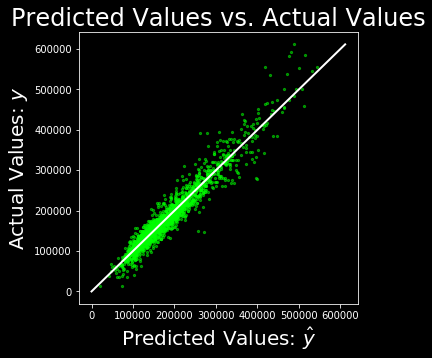

In [62]:
#Plotting 6th  LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(lr.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [63]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

X_kaggle_poly = poly.fit_transform(kaggle[for_poly])
# Convert X_poly to a DataFrame
new_kaggle_poly_df = pd.DataFrame(X_kaggle_poly, columns=poly.get_feature_names(for_poly))

prediction_data = pd.concat((kaggle[revised_features], new_kaggle_poly_df[poly_revised_features]), axis=1)

kaggle_preds = np.exp(lr.predict(prediction_data))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [64]:
kaggle_predictions["SalePrice"].std()

81792.2076125801

In [65]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     179809.019159
std       81792.207613
min       52473.891667
25%      125660.772940
50%      156251.540866
75%      212644.545816
max      825012.141894
Name: SalePrice, dtype: float64

In [66]:
kaggle_predictions.to_csv("./submissions/7-features-predictions.csv", index=False)

In [89]:
y = train["saleprice"].map(np.log)

In [90]:
X = pd.concat((train[revised_features], X_poly[poly_revised_features]), axis=1)

In [105]:
X.shape

(2051, 85)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [109]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [110]:
from sklearn.linear_model import RidgeCV

In [111]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(X_train_sc, y_train)

In [112]:
# Here is the optimal value of alpha
ridge_model.alpha_

1.0

In [113]:
print(ridge_model.score(X_train_sc, y_train))
print(ridge_model.score(X_test_sc, y_test))

0.911725359040155
0.8832385303993514


In [114]:
X_sc = ss.transform(X)
train["salesprice_hat"] = np.exp(ridge_model.predict(X_sc))
train["salesprice_hat"].describe()

count      2051.000000
mean     180526.702575
std       76177.580733
min       22055.915716
25%      127868.310833
50%      160421.523301
75%      214682.046863
max      524915.211815
Name: salesprice_hat, dtype: float64

In [115]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,138724.845735,224.845735
5,190000,195889.113640,5889.113640
6,140000,146405.538335,6405.538335
7,142000,144513.467328,2513.467328
11,183600,190298.529669,6698.529669
...,...,...,...
2039,93900,86890.636882,7009.363118
2043,128000,125489.438244,2510.561756
2044,182000,173329.101066,8670.898934
2048,177000,167150.717867,9849.282133


In [116]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

X_kaggle_poly = poly.fit_transform(kaggle[for_poly])
# Convert X_poly to a DataFrame
new_kaggle_poly_df = pd.DataFrame(X_kaggle_poly, columns=poly.get_feature_names(for_poly))

prediction_data = pd.concat((kaggle[revised_features], new_kaggle_poly_df[poly_revised_features]), axis=1)
P_sc = ss.transform(prediction_data)

kaggle_preds = np.exp(ridge_model.predict(P_sc))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [117]:
kaggle_predictions["SalePrice"].std()

81169.67836614882

In [118]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     179418.153488
std       81169.678366
min       51271.573639
25%      126220.783569
50%      155797.303717
75%      212425.631544
max      827349.873827
Name: SalePrice, dtype: float64

In [181]:
kaggle_predictions.to_csv("./submissions/8-features-predictions.csv", index=False)

#### Contd. NEXT  --- > [4. Exploratory Data Analysis](./4_Exploratory_Data_Analysis.ipynb)